In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split 

from sklearn.model_selection import StratifiedKFold

import cudf 
from cuml.linear_model import LogisticRegression
from cuml.ensemble import RandomForestClassifier

import os,glob

In [2]:
project_dir = os.getcwd()
data_dir = os.path.join(project_dir, 'data')
data_csv = pd.read_csv(os.path.join(data_dir, 'train.csv'))

In [3]:
numerical_data  = data_csv.select_dtypes(include=[np.number])
corr_matrix     = numerical_data.corr()

diabetes_corr = corr_matrix['diagnosed_diabetes'].drop('diagnosed_diabetes').sort_values(ascending=False)
print(diabetes_corr.abs().head(10).index)

# fig, ax = plt.subplots(figsize=(10, 10)) 
# colors = ['green' if x > 0 else 'red' for x in diabetes_corr]
# diabetes_corr.plot(kind='barh', color=colors, figsize=(6, 6)) 

Index(['family_history_diabetes', 'age', 'systolic_bp', 'bmi',
       'ldl_cholesterol', 'triglycerides', 'cholesterol_total',
       'waist_to_hip_ratio', 'diastolic_bp', 'hypertension_history'],
      dtype='object')


In [4]:
for f in data_csv['gender'].unique():
    print(f)
    length = len(data_csv[data_csv['gender'] == f])
    print(data_csv[data_csv['gender'] == f]['diagnosed_diabetes'].value_counts() / length) 

Female
diagnosed_diabetes
1.0    0.622205
0.0    0.377795
Name: count, dtype: float64
Male
diagnosed_diabetes
1.0    0.624294
0.0    0.375706
Name: count, dtype: float64
Other
diagnosed_diabetes
1.0    0.640566
0.0    0.359434
Name: count, dtype: float64


In [5]:
cat_encodes = {
    'gender': {
        'Male': 1,
        'Female': 0,
        'Other': 1
        },
    'ethnicity': {
        'Hispanic': 1,
        'Black': 1,
        'Asian': 1,
        'White': 0,
        'Other': 1
        },
    'smoking_status': {
        'Current': 1,
        'Former': 1/2,
        'Never':0
        },
    'employment_status': {
        'Employed': 1,
        'Unemployed': 1/2,
        'Retired': 0,
        'Student': 0
        },
    'education_level': {
        'High School': 0,
        'Graduate': 0,
        'Post Graduate': 0,
        'No formal': 0
        },
    'income_level': {
        'Lower-Middle': 0, 
        'Upper-Middle': 0, 
        'Low': 0, 
        'Middle': 0, 
        'High': 0
        }
    }


cat_features = data_csv.select_dtypes(include=['object']).columns 
data_csv2 = data_csv.copy()

for f in cat_features: 
    data_csv2[f] = data_csv[f].map(cat_encodes[f])
    print(f'\n{f}')
    print( '- ' * 10)
    print(data_csv[f].value_counts())
    print(data_csv2[f].value_counts())

data_csv2 = data_csv2.drop(columns=['education_level', 'income_level']); del data_csv


gender
- - - - - - - - - - 
gender
Female    363237
Male      333085
Other       3678
Name: count, dtype: int64
gender
0    363237
1    336763
Name: count, dtype: int64

ethnicity
- - - - - - - - - - 
ethnicity
White       386153
Hispanic    129984
Black       106301
Asian        60120
Other        17442
Name: count, dtype: int64
ethnicity
0    386153
1    313847
Name: count, dtype: int64

education_level
- - - - - - - - - - 
education_level
Highschool      344145
Graduate        261268
Postgraduate     79642
No formal        14945
Name: count, dtype: int64
education_level
0.0    276213
Name: count, dtype: int64

income_level
- - - - - - - - - - 
income_level
Middle          290557
Lower-Middle    178570
Upper-Middle    127836
Low              85803
High             17234
Name: count, dtype: int64
income_level
0    700000
Name: count, dtype: int64

smoking_status
- - - - - - - - - - 
smoking_status
Never      494448
Current    103363
Former     102189
Name: count, dtype: int64
smoking

In [6]:
def clinical_features(df_raw):

    df = df_raw.copy()

    ### Risk Factors ###

    df['ada_risk_factor_count'] = (
        (df['gender'] == 'Male').astype(int)
        + (df['age'] > 35).astype(int)
        + (df['bmi'] >= 25).astype(int)
        + (df['bmi'] >= 30).astype(int)
        + (df['bmi'] >= 35).astype(int)
        + (df['physical_activity_minutes_per_week'] < 100).astype(int)
        + (df['systolic_bp'] >= 130) | (df['diastolic_bp'] >= 80).astype(int)
        + (df['hdl_cholesterol'] < 35).astype(int)
        + (df['triglycerides'] > 150).astype(int)
        + df['family_history_diabetes'] 
        + df['hypertension_history']  
        + df['cardiovascular_history'] 
        )

    df['bp_normal'] = (
        (df['systolic_bp'] < 120) & 
        (df['diastolic_bp'] < 80) ).astype(int)

    # LIFE STYLE
    df['toxic_lifestyle'] = (
        (df['diet_score'] < 5).astype(int) +
        (df['sleep_hours_per_day'] < 7).astype(int) +
        (df['screen_time_hours_per_day'] > 6).astype(int) +
        (df['alcohol_consumption_per_week'] > 7).astype(int) +
        (df['physical_activity_minutes_per_week'] < 100).astype(int)
    )
     
    # df['age_bmi'] = df['age'] * df['bmi']

    # df['age_family_history'] = df['age'] * df['family_history_diabetes']
    # df['bmi_family_history'] = df['bmi'] * df['family_history_diabetes']
    # df['age_bmi_family_history'] = df['age'] * df['bmi'] * df['family_history_diabetes']
    
    # cardiovascular burden 
    df['cardio_comorbidity_count'] = (
        df['hypertension_history'] +
        df['cardiovascular_history'] +
        df['family_history_diabetes']
    )

    return df

def risk_factors(df_raw):
    
    df = df_raw.copy()

    # 
    df['age_risk'] = (df['age'] > 35).astype(int)
    df['high_bmi'] = (df['bmi'] >= 25).astype(int)
    df['obese'] = (df['bmi'] >= 30).astype(int)
    df['severe_obesity'] = (df['bmi'] >= 35).astype(int)

    df['low_physical_activity'] = (df['physical_activity_minutes_per_week'] < 100).astype(int)
    df['high_bp'] = ((df['systolic_bp'] >= 130) | (df['diastolic_bp'] >= 80)).astype(int)
    df['low_hdl_cholesterol'] = (df['hdl_cholesterol'] < 35).astype(int)
    df['high_triglycerides'] = (df['triglycerides'] > 150).astype(int)

    df['bp_normal'] = (
        (df['systolic_bp'] < 120) & 
        (df['diastolic_bp'] < 80) ).astype(int)

    ## life style
    df['poor_diet'] = (df['diet_score'] < 5).astype(int)
    df['poor_sleep'] = (df['sleep_hours_per_day'] < 7).astype(int)
    df['long_screen_time'] = (df['screen_time_hours_per_day'] > 6).astype(int)
    df['alcoholic'] = (df['alcohol_consumption_per_week'] > 7).astype(int)

    return df
    
    
# data_csv3 = clinical_features(data_csv2)
data_csv3 = risk_factors(data_csv2); print( len(data_csv3.columns)); del data_csv2

37


<Axes: >

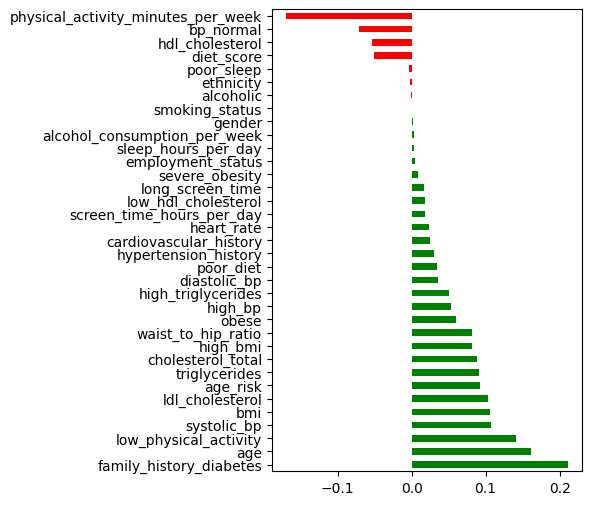

In [7]:
corr_matrix = data_csv3.drop(columns=['id']).corr()
diabetes_corr = corr_matrix['diagnosed_diabetes'].sort_values(ascending=False).drop('diagnosed_diabetes')

color = ['g' if x>0 else 'r' for x in diabetes_corr]
diabetes_corr.plot(kind='barh', figsize=(4, 6), color = color)

In [8]:
top_features = diabetes_corr.abs().sort_values(ascending=False).head(18).index.tolist(); print(top_features)

['family_history_diabetes', 'physical_activity_minutes_per_week', 'age', 'low_physical_activity', 'systolic_bp', 'bmi', 'ldl_cholesterol', 'age_risk', 'triglycerides', 'cholesterol_total', 'high_bmi', 'waist_to_hip_ratio', 'bp_normal', 'obese', 'high_bp', 'hdl_cholesterol', 'high_triglycerides', 'diet_score']


In [9]:
from itertools import combinations
import cupy as cp

new_features = {}
data_gpu = cudf.DataFrame(data_csv3)


exclude_features = ['family_history_diabetes', 'physical_activity_minutes_per_week', 'low_physical_activity', 'age']


for f1, f2 in combinations(top_features, 2):
    if f1 not in exclude_features and f2 not in exclude_features:
        new_features[f'{f1} MUL {f2}'] = data_gpu[f1] * data_gpu[f2]
        new_features[f'{f1} ADD {f2}'] = data_gpu[f1] + data_gpu[f2]
        new_features[f'{f1} SUB {f2}'] = data_gpu[f1] - data_gpu[f2]
        new_features[f'{f1} DIV {f2}'] = data_gpu[f1] / (1 + data_gpu[f2])

for f in top_features:
    if f not in exclude_features:
        unique_values = set(data_csv3[f].unique())
        if not unique_values.issubset({0, 1, 0.0, 1.0}):
            new_features[f'{f} ** 2'] = data_gpu[f] ** 2
            new_features[f'{f} ** 3'] = data_gpu[f] ** 3
            new_features[f'sqrt({f})'] = cp.sqrt(cp.abs(data_gpu[f])) 
    
# new_features = pd.DataFrame(new_features)
# data_csv4 = pd.concat([data_csv3, new_features], axis=1); del data_csv3

new_features = cudf.DataFrame(new_features)
data_gpu = cudf.concat([ data_gpu, new_features], axis=1)

In [10]:
corr_matrix4 = data_gpu.drop(columns=['id']).corr()

In [11]:
diabetes_corr = corr_matrix4['diagnosed_diabetes'].sort_values(ascending=False).drop('diagnosed_diabetes')
diabetes_corr = corr_matrix4['diagnosed_diabetes'].to_pandas() 

<Axes: >

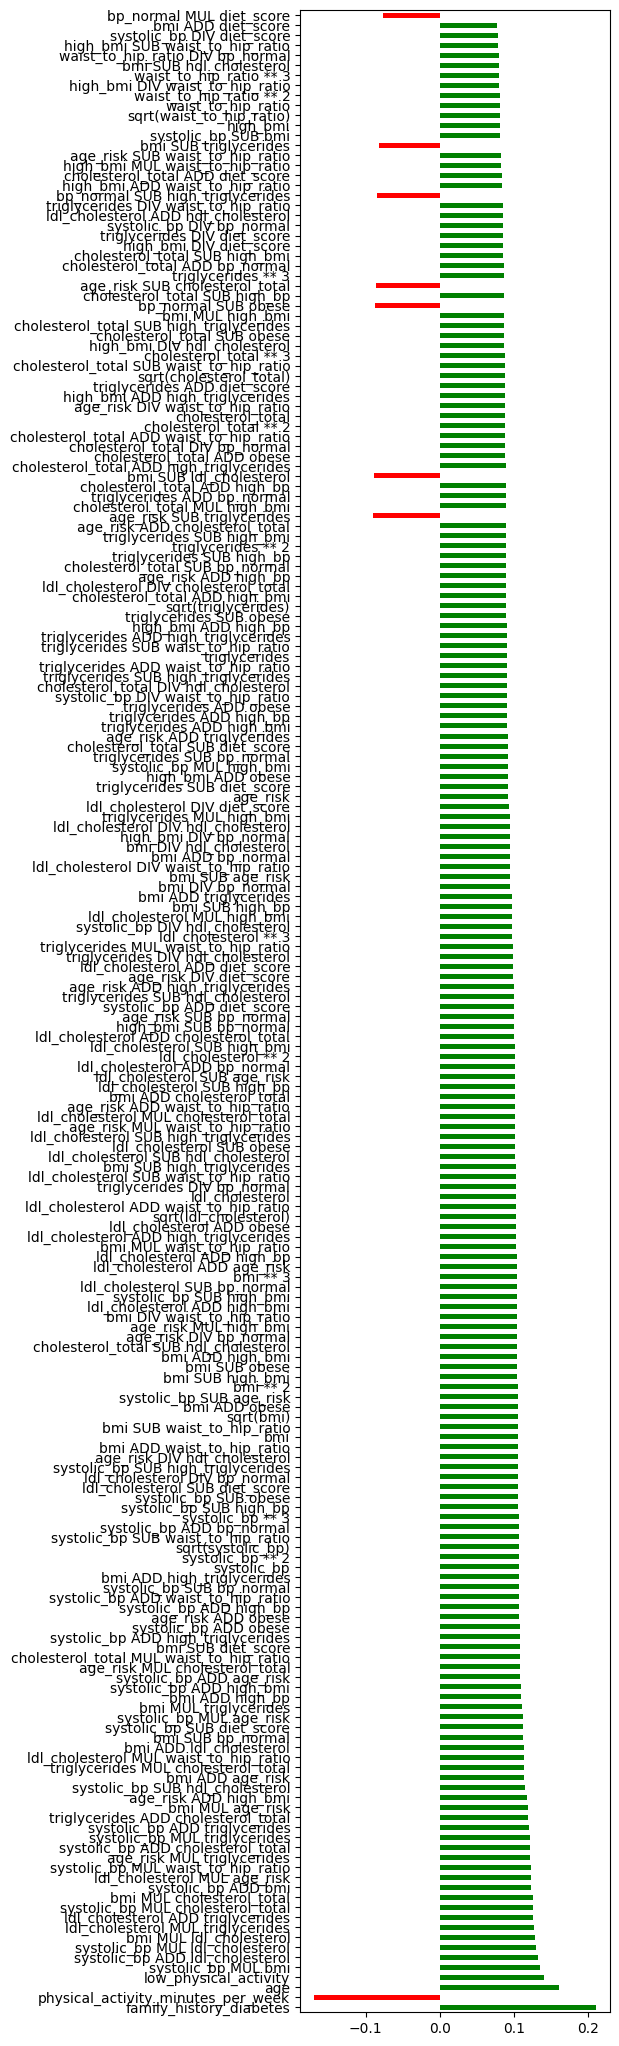

In [12]:
top_n_features = 200
selected_features = diabetes_corr.abs().sort_values(ascending=False).drop('diagnosed_diabetes').head(top_n_features).index.tolist()
# print(top_features4)

color4 = ['g' if x>0 else 'r' for x in diabetes_corr[selected_features]]
diabetes_corr[selected_features].plot(kind='barh', figsize=(4, 26), color = color4)

In [13]:
# for f in selected_features:
#     print(data_gpu[f].isna().unique())

In [14]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from cuml.ensemble import RandomForestClassifier
from cuml.linear_model import LogisticRegression
 

max_iter = 2000
c_value  = 1.0
random_state = 8964

models = {
    'Logistic (L2)' : LogisticRegression(penalty='l2', C= c_value, max_iter=max_iter),
    'Logistic (L1)' : LogisticRegression(penalty='l1', C= c_value, max_iter=max_iter),
    'Logistic ElasticNet' : LogisticRegression(penalty='elasticnet', C= c_value, max_iter=max_iter, l1_ratio=0.5),
    'RandomForest'  : RandomForestClassifier(n_estimators=100, max_depth=6, random_state=random_state),
    'XGBoost'       : XGBClassifier(tree_method = 'hist', n_estimators=200, device = 'cuda' ,learning_rate=0.1, max_depth=8, reg_alpha=1.0, reg_lambda=1.0, min_child_weight=3, random_state=random_state),
    'LightGBM'      : LGBMClassifier(n_estimators=200, device='gpu', learning_rate=0.1, max_depth=6, reg_alpha=1.0, reg_lambda=1.0, random_state=random_state, verbosity = 0),
    'CatBoost'      : CatBoostClassifier(n_estimators=200, task_type='GPU', learning_rate=0.1, max_depth=6,  random_state=random_state, verbose = False)
}

In [15]:
from cuml.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

train_data , test_data = train_test_split(data_gpu, test_size=0.2, random_state=8964)
print("  train - test data splited " )

n_fold = 5 

stratified_kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=8964)
kfold = stratified_kfold.split(train_data, train_data['diagnosed_diabetes'])

numerical_features = train_data.select_dtypes(include=[np.number]).columns.tolist()

results=[]

for i, (train_idx, valid_idx) in enumerate(kfold):
    print(f'\nFold {i+1} : train_idx {len(train_idx)}, valid_idx {len(valid_idx)}')
    print('- ' * 16)

    train_fold = train_data.iloc[train_idx.get()]
    valid_fold = train_data.iloc[valid_idx.get()]

    train_inputs = train_fold[selected_features]
    valid_inputs = valid_fold[selected_features]

    train_target = train_fold['diagnosed_diabetes']
    valid_target = valid_fold['diagnosed_diabetes']
    
    for name, model in models.items():
        if 'Logistic' in name or 'RandomForest' in name:

            # model fit and predictions
            model.fit(train_inputs, train_target)
            pred        = model.predict(valid_inputs)
            pred_proba  = model.predict_proba(valid_inputs)

            # to cpus
            pred_proba = pred_proba.values.get()[:, 1]
            pred = pred.values.get() 
            valid_target_pd = valid_target.to_pandas()
        else:

            # to cpus
            train_inputs_pd = train_inputs.to_pandas()
            valid_inputs_pd = valid_inputs.to_pandas()
            train_target_pd = train_target.to_pandas()
            valid_target_pd = valid_target.to_pandas()

            # then back to gpus and output in cpus
            model.fit(train_inputs_pd, train_target_pd)
            pred = model.predict(valid_inputs_pd)
            pred_proba = model.predict_proba(valid_inputs_pd)[:, 1]

        acc = accuracy_score(pred, valid_target_pd)
        auc = roc_auc_score(valid_target_pd, pred_proba)

        print(f"Model: {name},  Accuracy: {acc:.4f}, ROC-AUC: {auc:.4f}")
        results.append({'Fold': i, 'Model': name, 'Accuracy': acc, 'ROC-AUC': auc})
     
    print('-' * 16)


  train - test data splited 

Fold 1 : train_idx 447999, valid_idx 112001
- - - - - - - - - - - - - - - - 
Model: Logistic (L2),  Accuracy: 0.6245, ROC-AUC: 0.5919
Model: Logistic (L1),  Accuracy: 0.6233, ROC-AUC: 0.5837
Model: Logistic ElasticNet,  Accuracy: 0.6233, ROC-AUC: 0.5837
Model: RandomForest,  Accuracy: 0.6492, ROC-AUC: 0.6726


/scratch/k/K.Choi/diabetes-diagonsis/stats_tools/lib/python3.12/site-packages/xgboost/core.py:774: UserWarning: [14:56:59] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


Model: XGBoost,  Accuracy: 0.6817, ROC-AUC: 0.7215
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Model: LightGBM,  Accuracy: 0.6817, ROC-AUC: 0.7235
Model: CatBoost,  Accuracy: 0.6772, ROC-AUC: 0.7169
----------------

Fold 2 : train_idx 447999, valid_idx 112001
- - - - - - - - - - - - - - - - 
Model: Logistic (L2),  Accuracy: 0.6248, ROC-AUC: 0.5905
Model: Logistic (L1),  Accuracy: 0.6232, ROC-AUC: 0.5812
Model: Logistic ElasticNet,  Accuracy: 0.6232, ROC-AUC: 0.5812
Model: RandomForest,  Accuracy: 0.6484, ROC

In [16]:
results_df = pd.DataFrame(results)
display(results_df)

,Fold,Model,Accuracy,ROC-AUC
0,0,Logistic (L2),0.624459,0.591912
1,0,Logistic (L1),0.623253,0.583705
2,0,Logistic ElasticNet,0.623253,0.583705
3,0,RandomForest,0.649155,0.672555
4,0,XGBoost,0.681690,0.721475
5,0,LightGBM,0.681681,0.723489
6,0,CatBoost,0.677217,0.716860
7,1,Logistic (L2),0.624825,0.590526
8,1,Logistic (L1),0.623182,0.581227
9,1,Logistic ElasticNet,0.623182,0.581227


In [17]:
 
majority_baseline = train_target.value_counts(normalize=True).max()

print(f"\n    majority class baseline: {majority_baseline:.4f}")
print("- "*10)
print("\n     model performance")

model_performance = results_df.groupby('Model').agg({
    'Accuracy': ['mean', 'std'],
    'ROC-AUC': ['mean', 'std']
}).round(4)

print(model_performance)

print("- " * 10)
print("\n      best model by AUC")
auc_list = results_df.groupby('Model')['ROC-AUC'].mean().sort_values(ascending=False)
print(auc_list)


    majority class baseline: 0.6232
- - - - - - - - - - 

     model performance
                    Accuracy         ROC-AUC        
                        mean     std    mean     std
Model                                               
CatBoost              0.6769  0.0015  0.7167  0.0018
LightGBM              0.6816  0.0009  0.7229  0.0012
Logistic (L1)         0.6473  0.0220  0.6494  0.0611
Logistic (L2)         0.6242  0.0008  0.5873  0.0041
Logistic ElasticNet   0.6472  0.0220  0.6494  0.0612
RandomForest          0.6482  0.0013  0.6719  0.0015
XGBoost               0.6810  0.0007  0.7207  0.0009
- - - - - - - - - - 

      best model by AUC
Model
LightGBM               0.722851
XGBoost                0.720703
CatBoost               0.716749
RandomForest           0.671872
Logistic ElasticNet    0.649448
Logistic (L1)          0.649370
Logistic (L2)          0.587307
Name: ROC-AUC, dtype: float64


                                  feature  importance
0                 family_history_diabetes    0.422786
2                                     age    0.026155
1      physical_activity_minutes_per_week    0.024155
20                       bmi MUL age_risk    0.018662
133  triglycerides SUB high_triglycerides    0.014375


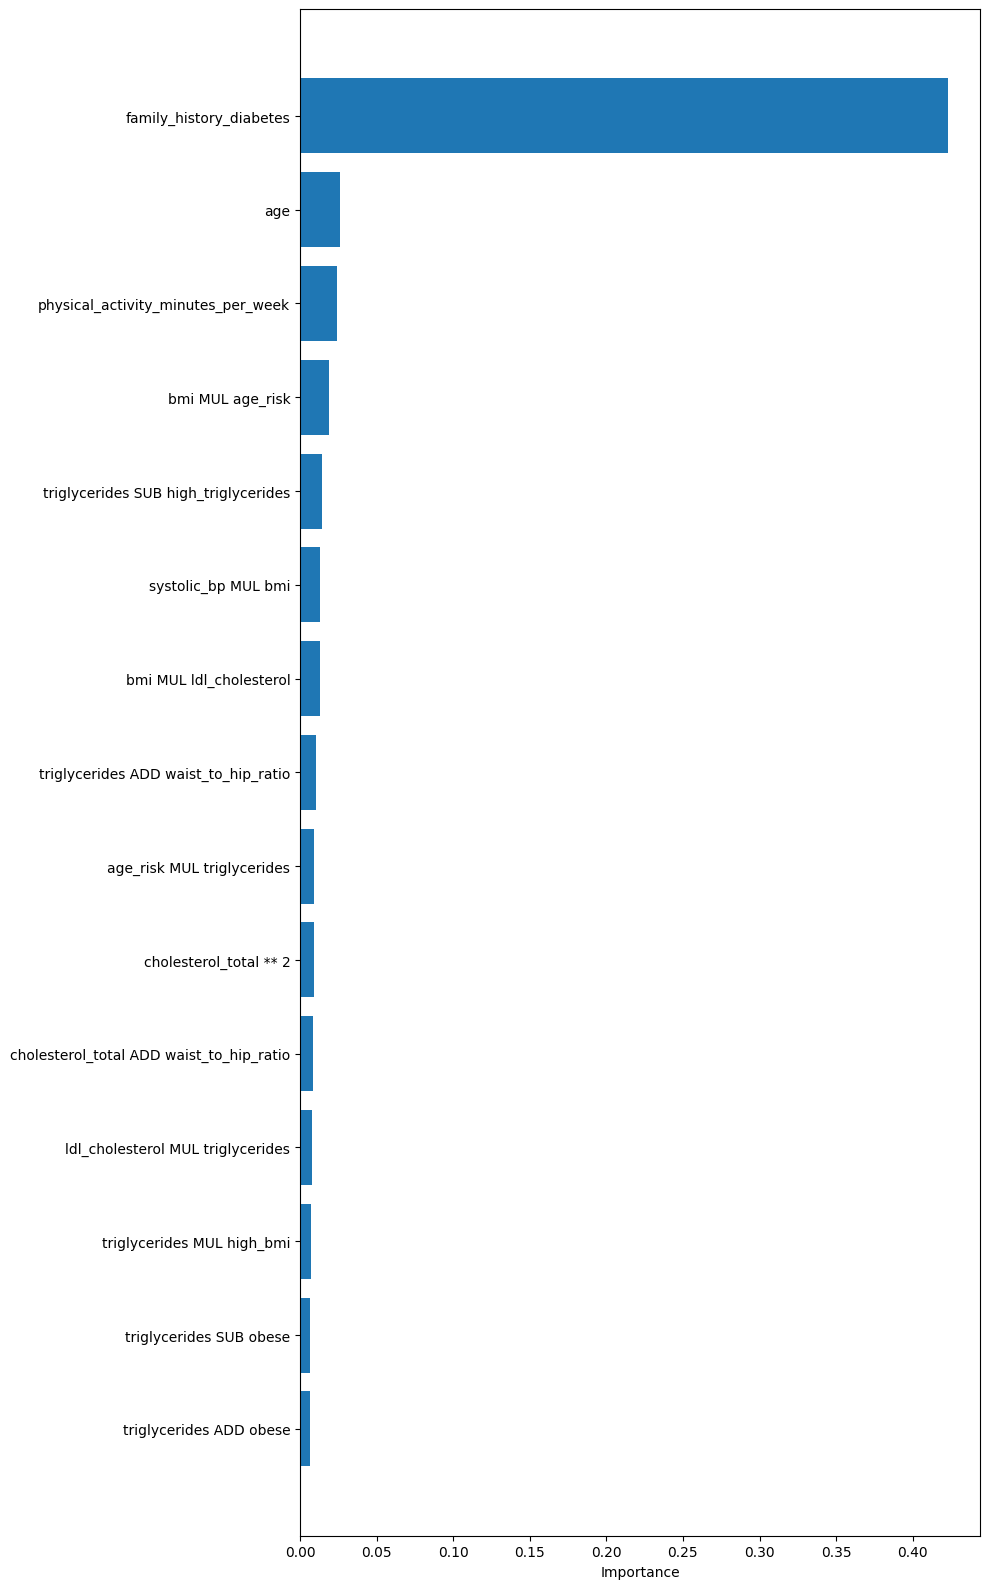

In [18]:
best_model = XGBClassifier( tree_method = 'hist', device = 'cuda', n_estimators = 100, max_depth = 6)
best_model.fit(train_inputs, train_target)

importance_df = pd.DataFrame({
    'feature' : train_inputs.columns,
    'importance' : best_model.feature_importances_}).sort_values('importance', ascending = False)

print(importance_df.head())

plt.figure(figsize=(10, 16))
plt.barh(importance_df['feature'].head(15), 
         importance_df['importance'].head(15))
plt.xlabel('Importance') 
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

train_size:  44800, auc: 0.6967, false_positive: 25083, false_negative: 12531
train_size: 931842, auc: 0.7162, false_positive: 24695, false_negative: 11374
train_size: 1818884, auc: 0.7162, false_positive: 24695, false_negative: 11374
train_size: 2705926, auc: 0.7162, false_positive: 24695, false_negative: 11374
train_size: 3592968, auc: 0.7162, false_positive: 24695, false_negative: 11374
train_size: 4480010, auc: 0.7162, false_positive: 24695, false_negative: 11374


/scratch-local/slurm-job-tmp-11899689/ipykernel_5422/594482448.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes.legend()


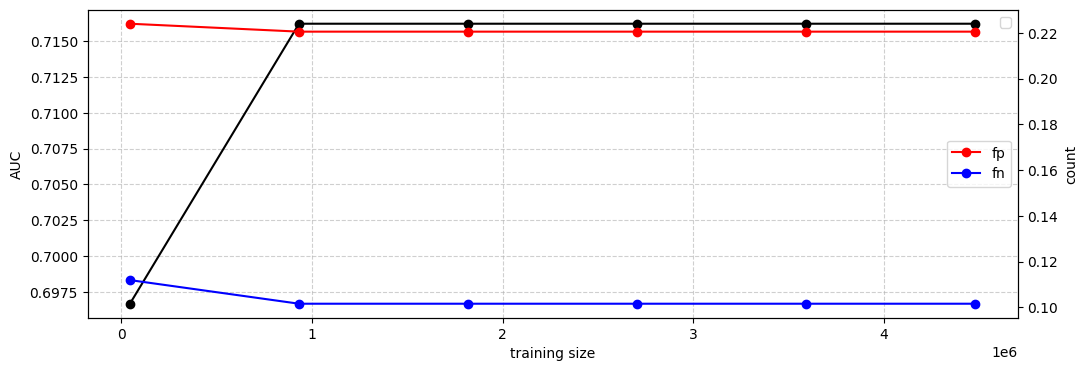

In [22]:
train_size = np.linspace(0.1,10,6)

learning_data = []

for size in train_size:

    sample_size = int(len(train_inputs) * size)

    input_sample  = train_inputs_pd.iloc[:sample_size]
    target_sample = train_target_pd.iloc[:sample_size]

    model = XGBClassifier(tree_method = 'hist', device = 'cuda', n_estimators = 100, max_depth = 6)
    
    model.fit(input_sample, target_sample)
    pred = model.predict(valid_inputs_pd)
    pred_proba = model.predict_proba(valid_inputs_pd)[:, 1]  
    
    auc = roc_auc_score(valid_target_pd, pred_proba)
    cm  = confusion_matrix(valid_target_pd, pred)
    tn, fp, fn, tp = cm.ravel()

    learning_data.append({'train_size': sample_size, 'auc': auc, 'fp': fp/len(valid_target), 'fn': fn/len(valid_target)})
    
    print(f'train_size: {sample_size:6d}, auc: {auc:.4f}, false_positive: {fp}, false_negative: {fn}')

lc_df = pd.DataFrame(learning_data)

fig,axes = plt.subplots(1,1,figsize=(12, 4))

axes.plot(lc_df['train_size'], lc_df['auc'], marker='o', c='k')
axes.set_xlabel('training size')
axes.set_ylabel('AUC')
axes.grid(True,alpha=0.6,linestyle='--')
axes.legend()

ax1 = axes.twinx()
ax1.plot(lc_df['train_size'], lc_df['fp'], marker='o', label='fp', c='r')
ax1.plot(lc_df['train_size'], lc_df['fn'], marker='o', label='fn', c='b')
ax1.set_ylabel('count')
ax1.legend(); plt.show()


